# Logistic Regression from Scratch with Gradient Descent

In this notebook, I implement binary logistic regression from scratch using NumPy.

I start from the mathematical formulation, derive the gradient of the binary cross-entropy loss,
and then implement gradient descent to train a classifier on a simple 2D synthetic dataset.


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(0)

# Make sure the figures folder exists
os.makedirs("figures", exist_ok=True)


## 1. Mathematical formulation

We consider a binary classification problem with:

- Input vectors $x^{(i)} \in \mathbb{R}^n$, for $i = 1, \dots, m$
- Binary labels $y^{(i)} \in \{0, 1\}$

We stack them as:

- Data matrix $X \in \mathbb{R}^{n \times m}$ whose columns are the vectors $x^{(i)}$
- Label row vector $Y \in \{0, 1\}^{1 \times m}$

### Logistic model

We use the logistic model
$$
\hat{y}^{(i)} = \sigma(w^\top x^{(i)} + b),
$$
where

- $w \in \mathbb{R}^n$ is the weight vector,
- $b \in \mathbb{R}$ is the bias,
- $\sigma(z)$ is the sigmoid function
$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

We interpret $\hat{y}^{(i)}$ as the estimated probability
$$
\hat{y}^{(i)} = \mathbb{P}(y^{(i)} = 1 \mid x^{(i)}).
$$

### Loss function

For one sample $(x^{(i)}, y^{(i)})$, the binary cross-entropy loss is
$$
\ell^{(i)}(w, b) =
- \Big[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \Big].
$$

For the whole dataset, the empirical risk (average loss) is
$$
J(w, b) = \frac{1}{m} \sum_{i=1}^m \ell^{(i)}(w, b).
$$

Our goal is to find $w, b$ that minimise $J(w, b)$.

### Gradient of the loss

Let $Z = w^\top X + b$ be a row vector in $\mathbb{R}^{1 \times m}$,
$\hat{Y} = A = \sigma(Z)$ the row vector of predictions, and $Y$ the row vector of labels.

Then the gradient of the loss is given by
$$
\frac{\partial J}{\partial w}
= \frac{1}{m} X (A - Y)^\top, \qquad
\frac{\partial J}{\partial b}
= \frac{1}{m} \sum_{i=1}^m \big( \hat{y}^{(i)} - y^{(i)} \big).
$$

This leads to the gradient descent updates
$$
w \leftarrow w - \alpha \frac{\partial J}{\partial w}, \qquad
b \leftarrow b - \alpha \frac{\partial J}{\partial b},
$$
where $\alpha > 0$ is the learning rate.


## 2. Generating a 2D synthetic dataset

We generate two Gaussian clusters in 2D, corresponding to the two classes.
This allows us to visualise both the data and the learned decision boundary.


X_T shape: (2, 400)
y_T shape: (1, 400)


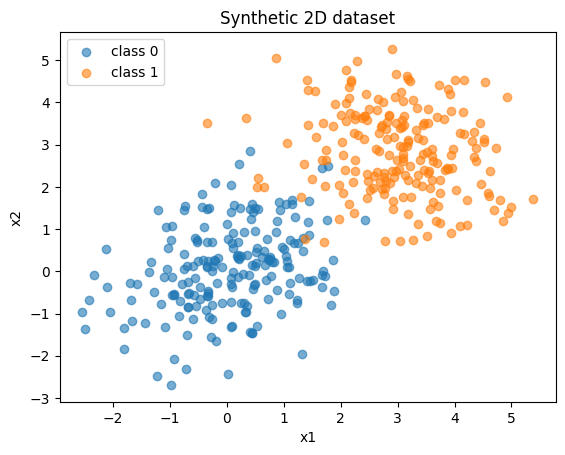

In [5]:
m_per_class = 200  # number of samples per class

# Class 0
mean0 = np.array([0.0, 0.0])
cov0 = np.array([[1.0, 0.3],
                 [0.3, 1.0]])
X0 = np.random.multivariate_normal(mean0, cov0, m_per_class)

# Class 1
mean1 = np.array([3.0, 3.0])
cov1 = np.array([[1.0, -0.2],
                 [-0.2, 1.0]])
X1 = np.random.multivariate_normal(mean1, cov1, m_per_class)

# Stack data
X = np.vstack([X0, X1])                 # shape (400, 2)
y = np.hstack([np.zeros(m_per_class),
               np.ones(m_per_class)])   # shape (400,)

# Transpose to (n_features, m)
X_T = X.T                               # shape (2, 400)
y_T = y.reshape(1, -1)                  # shape (1, 400)

print("X_T shape:", X_T.shape)
print("y_T shape:", y_T.shape)

# Visualise the dataset
plt.figure()
plt.scatter(X0[:, 0], X0[:, 1], alpha=0.6, label="class 0")
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.6, label="class 1")
plt.legend()
plt.title("Synthetic 2D dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


## 3. Implementing logistic regression components

We now implement the building blocks:

1. The sigmoid activation function
2. A function to compute the loss and its gradients with respect to \(w\) and \(b\)
3. Gradient descent to optimise \(w\) and \(b\)
4. A prediction function that maps inputs to class labels \(\{0, 1\}\)


In [7]:
def sigmoid(z):
    """
    Compute the sigmoid function elementwise.
    """
    return 1 / (1 + np.exp(-z))


def compute_loss_and_grads(X, Y, w, b):
    """
    Compute the binary cross-entropy loss and its gradients.

    X: shape (n_features, m)
    Y: shape (1, m)
    w: shape (n_features, 1)
    b: scalar
    """
    m = X.shape[1]

    Z = np.dot(w.T, X) + b          # shape (1, m)
    A = sigmoid(Z)                  # predictions, shape (1, m)

    # Avoid log(0)
    eps = 1e-15
    loss = -(1 / m) * np.sum(
        Y * np.log(A + eps) + (1 - Y) * np.log(1 - A + eps)
    )

    dZ = A - Y                      # shape (1, m)
    dw = (1 / m) * np.dot(X, dZ.T)  # shape (n_features, 1)
    db = (1 / m) * np.sum(dZ)       # scalar

    return loss, dw, db


def gradient_descent(X, Y, lr=0.1, num_iter=2000, print_every=200):
    """
    Run gradient descent for a fixed number of iterations.

    Returns:
    - w, b: learned parameters
    - losses: list of loss values recorded every 'print_every' iterations
    """
    n_features = X.shape[0]
    w = np.zeros((n_features, 1))
    b = 0.0

    losses = []

    for i in range(num_iter):
        loss, dw, db = compute_loss_and_grads(X, Y, w, b)

        # Parameter updates
        w -= lr * dw
        b -= lr * db

        if i % print_every == 0:
            losses.append(loss)
            print(f"Iteration {i:4d} | loss = {loss:.4f}")

    return w, b, losses


def predict(X, w, b):
    """
    Predict binary labels {0,1} for given inputs X using learned parameters.
    """
    Z = np.dot(w.T, X) + b          # shape (1, m)
    A = sigmoid(Z)
    return (A > 0.5).astype(int)    # shape (1, m)


## 4. Training the model

We train the model using gradient descent with a fixed learning rate and number of iterations.


In [8]:
lr = 0.1
num_iter = 2000
print_every = 100

w, b, losses = gradient_descent(
    X_T, y_T, lr=lr, num_iter=num_iter, print_every=print_every
)

print("Learned w:", w.ravel())
print("Learned b:", b)


Iteration    0 | loss = 0.6931
Iteration  100 | loss = 0.2243
Iteration  200 | loss = 0.1634
Iteration  300 | loss = 0.1360
Iteration  400 | loss = 0.1204
Iteration  500 | loss = 0.1102
Iteration  600 | loss = 0.1031
Iteration  700 | loss = 0.0978
Iteration  800 | loss = 0.0937
Iteration  900 | loss = 0.0904
Iteration 1000 | loss = 0.0877
Iteration 1100 | loss = 0.0855
Iteration 1200 | loss = 0.0837
Iteration 1300 | loss = 0.0821
Iteration 1400 | loss = 0.0807
Iteration 1500 | loss = 0.0795
Iteration 1600 | loss = 0.0785
Iteration 1700 | loss = 0.0775
Iteration 1800 | loss = 0.0767
Iteration 1900 | loss = 0.0760
Learned w: [1.85223763 1.64498543]
Learned b: -5.171483068564903


## 5. Visualising the loss curve

We plot the loss values recorded during training to see how the optimisation progresses.


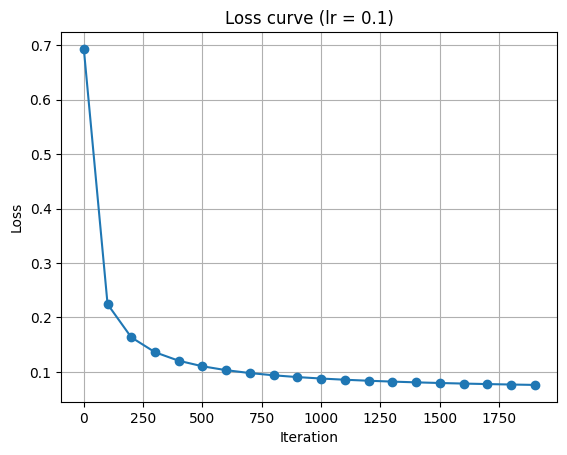

In [9]:
iterations_recorded = np.arange(0, num_iter, print_every)

plt.figure()
plt.plot(iterations_recorded, losses, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Loss curve (lr = {lr})")
plt.grid(True)
plt.savefig("figures/loss_curve.png", dpi=200, bbox_inches="tight")
plt.show()


## 6. Visualising the decision boundary

Since the data are 2-dimensional, we can plot the learned linear decision boundary
together with the data points.


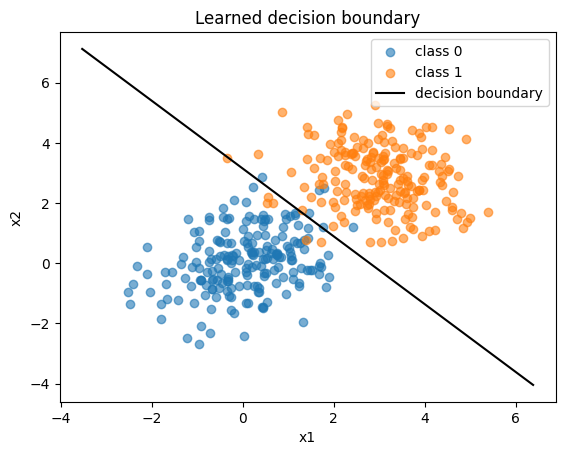

In [10]:
plt.figure()
plt.scatter(X0[:, 0], X0[:, 1], alpha=0.6, label="class 0")
plt.scatter(X1[:, 0], X1[:, 1], alpha=0.6, label="class 1")

# Decision boundary: w1 * x1 + w2 * x2 + b = 0
# => x2 = -(w1 * x1 + b) / w2
x1_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
w1, w2 = w[0, 0], w[1, 0]
x2_vals = -(w1 * x1_vals + b) / w2

plt.plot(x1_vals, x2_vals, "k-", label="decision boundary")

plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Learned decision boundary")
plt.savefig("figures/decision_boundary.png", dpi=200, bbox_inches="tight")
plt.show()


## 7. Evaluation

We evaluate the classifier on the training data using accuracy.


In [11]:
y_pred = predict(X_T, w, b)        # shape (1, m)
accuracy = np.mean(y_pred == y_T)
print(f"Training accuracy: {accuracy * 100:.2f}%")


Training accuracy: 97.00%


## 8. Effect of the learning rate 

We now repeat the experiment for several different learning rates to see
how they affect convergence behaviour.



=== Training with lr = 0.001 ===
Iteration    0 | loss = 0.6931
Iteration  100 | loss = 0.6115
Iteration  200 | loss = 0.5593
Iteration  300 | loss = 0.5243
Iteration  400 | loss = 0.4994
Iteration  500 | loss = 0.4809
Iteration  600 | loss = 0.4664
Iteration  700 | loss = 0.4546
Iteration  800 | loss = 0.4448
Iteration  900 | loss = 0.4363
Iteration 1000 | loss = 0.4288
Iteration 1100 | loss = 0.4221
Iteration 1200 | loss = 0.4160
Iteration 1300 | loss = 0.4103
Iteration 1400 | loss = 0.4051
Iteration 1500 | loss = 0.4001
Iteration 1600 | loss = 0.3955
Iteration 1700 | loss = 0.3910
Iteration 1800 | loss = 0.3867
Iteration 1900 | loss = 0.3826

=== Training with lr = 0.01 ===
Iteration    0 | loss = 0.6931
Iteration  100 | loss = 0.4286
Iteration  200 | loss = 0.3786
Iteration  300 | loss = 0.3449
Iteration  400 | loss = 0.3180
Iteration  500 | loss = 0.2958
Iteration  600 | loss = 0.2771
Iteration  700 | loss = 0.2611
Iteration  800 | loss = 0.2473
Iteration  900 | loss = 0.2353
Ite

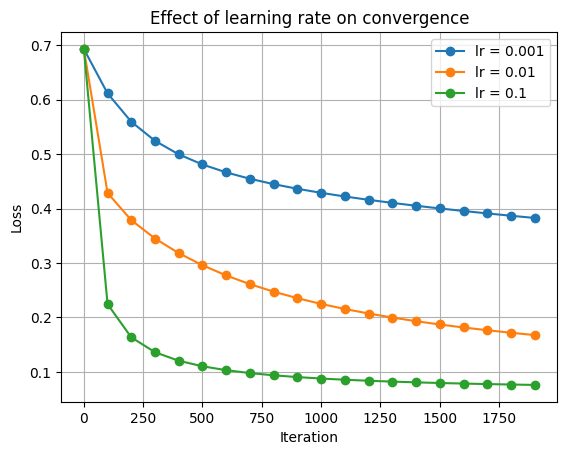

In [12]:
def train_with_lr_list(X, Y, lr_list, num_iter=2000, print_every=200):
    history = {}

    for lr_val in lr_list:
        print(f"\n=== Training with lr = {lr_val} ===")
        w_lr, b_lr, losses_lr = gradient_descent(
            X, Y, lr=lr_val, num_iter=num_iter, print_every=print_every
        )
        history[lr_val] = (w_lr, b_lr, losses_lr)

    return history

lr_list = [0.001, 0.01, 0.1]
num_iter_exp = 2000
print_every_exp = 100

history = train_with_lr_list(
    X_T, y_T, lr_list, num_iter=num_iter_exp, print_every=print_every_exp
)

# Plot loss curves for different learning rates
plt.figure()
iterations_recorded_exp = np.arange(0, num_iter_exp, print_every_exp)

for lr_val in lr_list:
    _, _, losses_lr = history[lr_val]
    plt.plot(iterations_recorded_exp, losses_lr, marker="o", label=f"lr = {lr_val}")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Effect of learning rate on convergence")
plt.legend()
plt.grid(True)
plt.show()


## 9. Summary and discussion

In this notebook, I implemented logistic regression from scratch:

- Derived the binary cross-entropy loss and its gradients with respect to \(w\) and \(b\).
- Implemented gradient descent using these gradients.
- Trained the model on a 2D synthetic dataset and visualised the learned decision boundary.
- Observed how different learning rates affect convergence behaviour.

This small project helped me connect the mathematical formulation of logistic regression
with its practical implementation, and provides a first step towards more advanced topics
such as regularisation, stochastic gradient descent, and deep learning models.
